In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [130]:
import os
import pandas as pd
import nltk
import logging
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from gensim.utils import simple_preprocess
from collections import Counter
from functools import lru_cache
import matplotlib.pyplot as plt

In [131]:
# -------------------------------
# 0. Setup & Anti-Hallucination
# -------------------------------

logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

# Download NLTK resources quietly
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

comments_file = "comments.csv"
stopword_file = "tagalog_stopwords.txt"

if not os.path.exists(comments_file):
    raise FileNotFoundError(f"❌ Missing input file: {comments_file}")

if not os.path.exists(stopword_file):
    raise FileNotFoundError(f"❌ Missing stopword file: {stopword_file}")

In [132]:
# -------------------------------
# 1. Data Collection
# -------------------------------
df = pd.read_csv(comments_file)

if "Comments" not in df.columns:
    raise ValueError("❌ CSV file must have a 'Comments' column.")

if df.empty:
    raise ValueError("❌ CSV file is empty. Cannot run topic modeling.")

print("✅ Dataset loaded successfully!")
print("Dataset shape:", df.shape)
print("First 5 rows:\n", df.head())

✅ Dataset loaded successfully!
Dataset shape: (978, 1)
First 5 rows:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


In [133]:
# -------------------------------
# 2. Stopword Preparation
# -------------------------------
with open(stopword_file, "r", encoding="utf-8") as f:
    tagalog_stopwords = set([line.strip() for line in f if line.strip()])

# Combine English + Tagalog stopwords
all_stopwords = set(stopwords.words("english")).union(tagalog_stopwords)
print(f"✅ Loaded {len(all_stopwords)} total stopwords.")

✅ Loaded 488 total stopwords.


In [137]:
# -------------------------------
# 3. Preprocessing
# -------------------------------
lemmatizer = WordNetLemmatizer()

from functools import lru_cache
@lru_cache(maxsize=100000)
def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

def preprocess(text):
    """
    Tokenize, clean, lemmatize, and remove stopwords.
    Drops 1-2 character tokens like 'm', 'u', 'ma', 'ta'.
    """
    tokens = simple_preprocess(str(text), deacc=True)
    clean_tokens = []
    for t in tokens:
        t = t.strip()
        if t and t.isalpha():  # keep only alphabetic tokens
            if t not in all_stopwords:  # check stopword membership
                if len(t) > 2:  # drop short words (1-2 letters)
                    clean_tokens.append(lemmatize_word(t))
    return clean_tokens

texts = df["Comments"].dropna().astype(str).tolist()
processed_texts = [preprocess(doc) for doc in texts]

# -------------------------------
# EXTRA FILTER: Remove specific 2-letter words manually
# -------------------------------
two_letter_exceptions = {"ma", "ta", "pa", "na", "sa", "ng", "go", "as", "dd", "po", "do", "ab"}  # add more if needed
processed_texts = [
    [t for t in doc if t not in two_letter_exceptions]
    for doc in processed_texts
]

# ✅ Debugging: check if problematic tokens still exist
all_tokens_flat = [t for doc in processed_texts for t in doc]
problematic_tokens = {t for t in all_tokens_flat if len(t) <= 2}
if problematic_tokens:
    print(f"⚠️ WARNING: Some short tokens still remain: {problematic_tokens}")
else:
    print("✅ All 1-2 letter tokens removed successfully.")

if not any(processed_texts):
    raise ValueError("❌ All tokens were removed after preprocessing. Check stopword list.")

print("\nSample preprocessed text:", processed_texts[0][:20])

✅ All 1-2 letter tokens removed successfully.

Sample preprocessed text: ['gumagalaw', 'romualdez', 'pinaka', 'suspicious']


In [138]:
# -------------------------------
# 4. Dictionary & Corpus
# -------------------------------
dictionary = Dictionary(processed_texts)
dictionary.filter_extremes(no_below=2, no_above=0.7)

if len(dictionary) == 0:
    raise ValueError("❌ Dictionary is empty after filtering. Try lowering 'no_above' or 'no_below'.")

corpus = [dictionary.doc2bow(text) for text in processed_texts]

In [139]:
# -------------------------------
# 5. Compute Optimal Number of Topics
# -------------------------------
def compute_coherence(dictionary, corpus, texts, limit, start=3, step=1):
    coherence_values = []
    model_list = []
    num_cores = max(1, multiprocessing.cpu_count() - 1)
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            iterations=400,
            random_state=42,
            alpha="symmetric",  # avoid auto-tuning (not supported in LdaMulticore)
            eta=None,
            chunksize=2000,
            eval_every=None,
            workers=num_cores
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence(dictionary, corpus, processed_texts, limit=11, start=3, step=1)

# ✅ Pick best number of topics based on coherence score
x = range(3, 11)
best_num = x[coherence_values.index(max(coherence_values))]
print(f"✅ Best number of topics: {best_num}")

✅ Best number of topics: 10


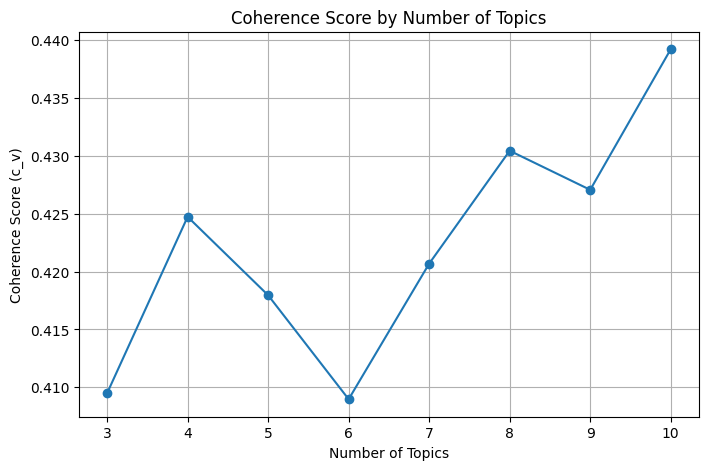

In [144]:
# -------------------------------
# 5b. Visualize Coherence Score
# -------------------------------
import matplotlib.pyplot as plt

x = list(range(3, 11))  # topic numbers we tested
plt.figure(figsize=(8, 5))
plt.plot(x, coherence_values, marker="o")
plt.title("Coherence Score by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.xticks(x)
plt.show()

In [140]:
# -------------------------------
# 6. Train Final Model
# -------------------------------
final_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num,
    passes=10,
    iterations=400,
    random_state=42,
    alpha="symmetric",
    eta=None,
    chunksize=2000,
    eval_every=None,
    workers=max(1, multiprocessing.cpu_count() - 1)
)

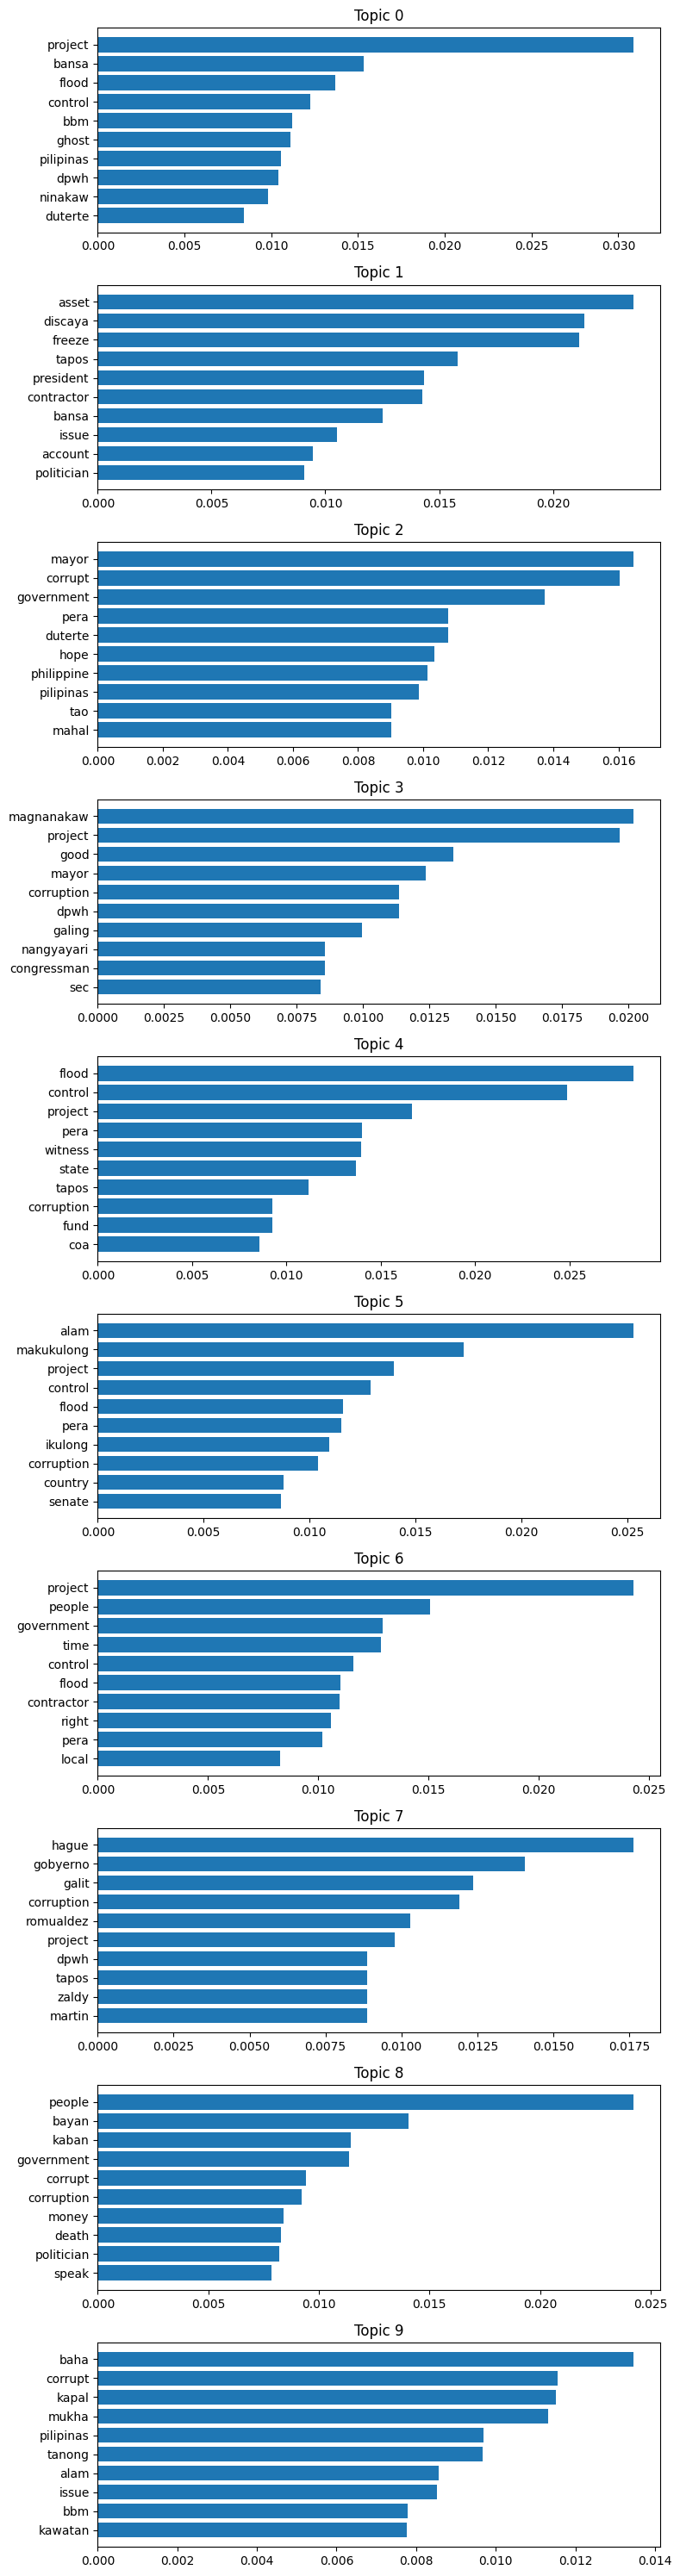

In [141]:
# -------------------------------
# 7. Display & Save Topics
# -------------------------------
topics_data = []
topics = final_model.show_topics(num_topics=best_num, num_words=10, formatted=False)

fig, axes = plt.subplots(nrows=len(topics), ncols=1, figsize=(8, len(topics) * 3))

if len(topics) == 1:
    axes = [axes]  # make iterable if only one topic

for (topic_idx, topic), ax in zip(topics, axes):
    words, weights = zip(*topic)
    topics_data.append({"Topic": topic_idx, "Words": ", ".join(words)})
    ax.barh(words, weights)
    ax.invert_yaxis()
    ax.set_title(f"Topic {topic_idx}")

plt.tight_layout()
plt.show()

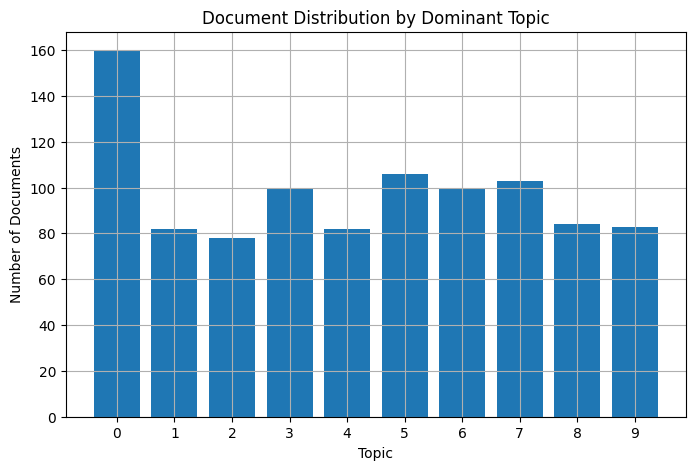

In [142]:
# -------------------------------
# 8. Topic Distribution Across Documents
# -------------------------------
doc_topics = []
for doc in corpus:
    topic_probs = final_model.get_document_topics(doc)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0] if topic_probs else -1
    doc_topics.append(dominant_topic)

plt.figure(figsize=(8, 5))
plt.hist([t for t in doc_topics if t >= 0], bins=range(best_num + 1), align="left", rwidth=0.8)
plt.xticks(range(best_num))
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Document Distribution by Dominant Topic")
plt.grid()
plt.show()

In [143]:
# -------------------------------
# 9. Summarize Topics into Text
# -------------------------------

def summarize_topics(model, num_words=10):
    """
    Summarize all topics into a single text string.
    Each topic is listed with its top words.
    """
    if model is None:
        print("⚠️ No model provided. Cannot summarize topics.")
        summarized_text = ""
    else:
        topics = model.show_topics(num_topics=model.num_topics, num_words=num_words, formatted=False)
        summarized_text = ""
        for idx, topic in topics:
            words = [w for w, _ in topic]
            summarized_text += f"Topic {idx}: {', '.join(words)}\n"

    print("\n--- Topic Summary ---\n")
    print(summarized_text)
    return summarized_text

# Call the function to display the summary
topic_summary_text = summarize_topics(final_model)



--- Topic Summary ---

Topic 0: project, bansa, flood, control, bbm, ghost, pilipinas, dpwh, ninakaw, duterte
Topic 1: asset, discaya, freeze, tapos, president, contractor, bansa, issue, account, politician
Topic 2: mayor, corrupt, government, pera, duterte, hope, philippine, pilipinas, tao, mahal
Topic 3: magnanakaw, project, good, mayor, corruption, dpwh, galing, nangyayari, congressman, sec
Topic 4: flood, control, project, pera, witness, state, tapos, corruption, fund, coa
Topic 5: alam, makukulong, project, control, flood, pera, ikulong, corruption, country, senate
Topic 6: project, people, government, time, control, flood, contractor, right, pera, local
Topic 7: hague, gobyerno, galit, corruption, romualdez, project, dpwh, tapos, zaldy, martin
Topic 8: people, bayan, kaban, government, corrupt, corruption, money, death, politician, speak
Topic 9: baha, corrupt, kapal, mukha, pilipinas, tanong, alam, issue, bbm, kawatan



In [147]:
# -------------------------------
# 10. Save & Load Model
# -------------------------------

model_path = "final_lda_model.gensim"
dictionary_path = "lda_dictionary.gensim"

final_model.save(model_path)
dictionary.save(dictionary_path)
print("✅ Model & dictionary saved!")

✅ Model & dictionary saved!
